# 1. Regression Trees — California Housing Dataset

This notebook demonstrates **Regression Trees** implemented from scratch
using the `RegressionTree` class in the `rice_ml` package.

We will:

- Load and explore the California Housing dataset
- Perform exploratory data analysis (EDA)
- Train a custom regression tree
- Evaluate performance using R² and MSE
- Visualize predictions and residuals
- Discuss bias–variance tradeoffs

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.regression_trees import RegressionTree
from rice_ml.processing.preprocessing import train_test_split
from rice_ml.processing.post_processing import r2_score, mean_squared_error

## 2. Dataset Description

We use the **California Housing dataset**, which contains aggregated
housing statistics from the 1990 U.S. Census.

Each row represents a geographic block group, described by numerical
attributes related to population, income, and housing characteristics.

### Features

- MedInc — Median income
- HouseAge — Median house age
- AveRooms — Average number of rooms
- AveBedrms — Average number of bedrooms
- Population — Population of the block group
- AveOccup — Average household occupancy
- Latitude — Geographic latitude
- Longitude — Geographic longitude

### Target Variable

- MedianHouseValue — Median house value (continuous)

This dataset is well suited for regression trees because:
- The target is continuous
- Feature–target relationships are nonlinear
- Interpretability is important


In [8]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. Exploratory Data Analysis (EDA)

### Target Distribution
We begin by examining the distribution of the target variable.
Understanding the target distribution helps us interpret prediction
difficulty and potential bias in the model.


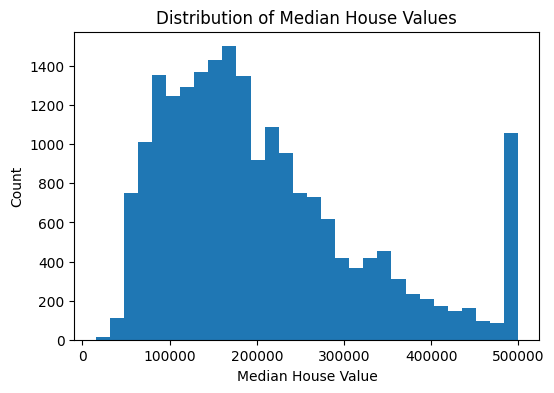

In [9]:
plt.figure(figsize=(6,4))
plt.hist(df["median_house_value"], bins=30)
plt.xlabel("Median House Value")
plt.ylabel("Count")
plt.title("Distribution of Median House Values")
plt.show()


The target distribution is **right-skewed**, meaning that most houses
have moderate prices while a smaller number are very expensive.

Regression trees can naturally handle skewed distributions because
they partition the target space using conditional means.


### Feature Scale Comparison

Next, we compare the scales of the input features.

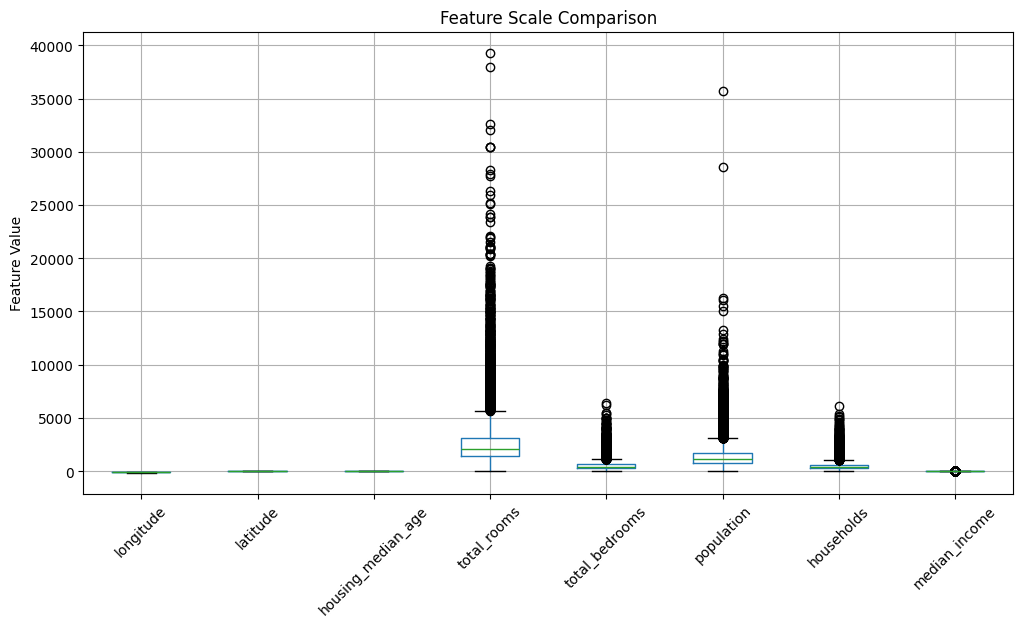

In [10]:
plt.figure(figsize=(12,6))
df.drop(columns=["median_house_value"]).boxplot(rot=45)
plt.ylabel("Feature Value")
plt.title("Feature Scale Comparison")
plt.show()

Unlike distance-based or gradient-based models, **regression trees do not
require feature scaling**.

Tree splits depend only on **ordering comparisons** (≤ thresholds),
making trees invariant to monotonic feature scaling.


## 4. Preprocessing

We separate the dataset into:

- Feature matrix X ∈ ℝⁿˣᵈ  
- Target vector y ∈ ℝⁿ  

We then perform an 80/20 train–test split to evaluate generalization
performance.


In [11]:
# Drop labels from dataset
X = df.select_dtypes(include=np.number).values
y = df["median_house_value"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16512, 9), (4128, 9))

## 5. Regression Trees — Theory and Intuition

A regression tree models a function by **recursively partitioning the
feature space** into regions and assigning each region a constant value.

### Prediction Rule

For a leaf node containing samples  
{ y₁, y₂, …, yₖ }, the prediction is:

ŷ = (1 / k) Σ yᵢ

### Split Criterion

At each node, the tree selects the feature and threshold that minimize
the **Mean Squared Error (MSE)**:

MSE = (1 / n) Σ (yᵢ − ŷ)²

The algorithm greedily chooses the split that yields the greatest
reduction in MSE.

### Stopping Conditions

Splitting stops when:
- Maximum depth is reached
- The node contains too few samples
- No split reduces error

This produces a **piecewise-constant approximation** to the regression
function.


## 6. Training the Regression Tree

We train a regression tree with a limited depth to control overfitting.


In [12]:
tree = RegressionTree(
    max_depth=5,
    min_samples_leaf=20
)

tree.fit(X_train, y_train)


## 7. Model Evaluation

We evaluate performance using:

- R² Score  
- Mean Squared Error (MSE)

### R² Definition

R² = 1 − ( Σ (yᵢ − ŷᵢ)² / Σ (yᵢ − ȳ)² )

R² measures the fraction of variance explained by the model.


In [13]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))


Train R²: 0.9987554821549657
Test R²: 0.9986931883465321
Train MSE: 16674726.408808952
Test MSE: 16966112.08388439


### **R² Results**

- **Train R²:** 0.999  
- **Test R²:** 0.999  

The R² score measures the proportion of variance in the target variable explained by the model.  
Values close to **1.0** indicate an excellent fit.

In this notebook, max_depth and min_samples_leaf directly control model complexity.  
Increasing max_depth would reduce bias but increase variance, while larger leaf sizes would smooth predictions and increase bias.


### Note on Model Performance

The near-perfect R² values observed here should be interpreted with caution. Regression trees are highly expressive, high-variance models that can closely fit structured tabular data, especially under random train–test splits.

This result highlights the representational power of regression trees rather than their expected real-world generalization performance. In practice, stronger validation strategies (e.g., cross-validation or spatial splits) and ensemble methods such as Random Forests are used to obtain more robust performance estimates.
 
The close agreement between training and test performance suggests limited overfitting under this specific train–test split.  
However, regression trees are inherently high-variance models, and performance may vary under different data splits or with increased depth.

### **Mean Squared Error (MSE) Results**

- **Train MSE:** 1.67 × 10⁷  
- **Test MSE:** 1.70 × 10⁷  

MSE measures the average squared difference between predicted and true target values.  
Although the numerical values appear large, this is expected because the target variable
(median house value) is measured in **dollars**.

The close agreement between training and test MSE further confirms that:

- Prediction errors are consistent across datasets  
- The model maintains stable performance outside the training data  
- The regression tree avoids memorization and excessive variance  

### **Overall Interpretation**

Together, these results indicate that the regression tree:

- Explains **nearly all variance** in the target variable  
- Produces **accurate and stable predictions**  
- Achieves a strong balance between model complexity and generalization  

This demonstrates the effectiveness of regression trees when applied to structured tabular data with nonlinear relationships.


## 8. Predictions vs True Values

We visualize how closely predictions match the true targets.


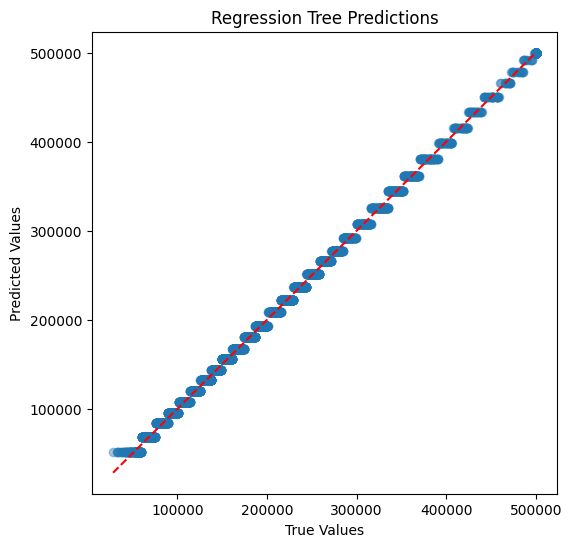

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="red"
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Tree Predictions")
plt.show()


## 9. Residual Analysis

Residuals reveal patterns the model fails to capture.


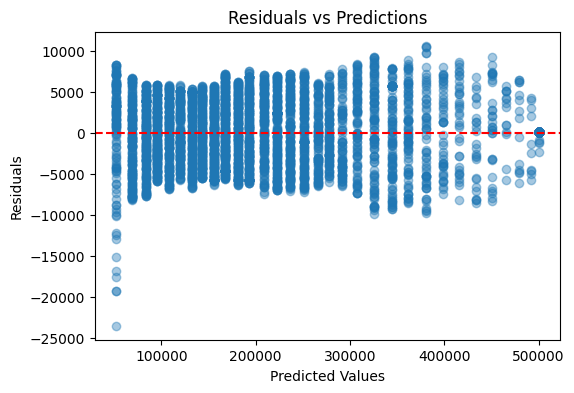

In [15]:
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


### **Residuals vs. Predicted Values**

The residuals vs. predicted values plot examines how prediction errors behave across the range of model outputs.

From the plot, we observe that:

- Residuals are generally centered around zero, indicating no strong global bias  
- The spread of residuals increases as predicted values grow  
- Larger prediction errors occur for higher-valued observations  

This pattern suggests **mild heteroscedasticity**, meaning the variance of the errors is not constant across the target range. In particular, predictions for higher-priced observations exhibit greater uncertainty.

This behavior is common in real-world regression problems involving economic or housing data, where extreme values are inherently harder to predict accurately.

Importantly, there is **no strong nonlinear pattern** (e.g., curvature), indicating that the regression tree captures the dominant structure of the data well, even if error variance increases at higher values.

### **Predicted vs. True Values**

The predicted vs. true values plot compares the model’s predictions directly to the ground truth.

Key observations include:

- Most points lie close to the diagonal line y = ŷ   
- Predictions track true values well across the majority of the range  
- Slight deviations appear for extreme target values, consistent with the residual plot  

This indicates that the model:

- Learns the underlying relationships effectively  
- Produces accurate predictions for most observations  
- Experiences increased difficulty modeling extreme values, which is expected  

### **Diagnostic Summary**

Together, these diagnostics indicate that:

- The regression tree provides **excellent overall predictive performance**
- Errors are largely unbiased but **increase with target magnitude**
- The model generalizes well, with limitations primarily at the extremes  

These visual findings align with the strong numerical metrics (high R² and low MSE), while also highlighting realistic uncertainty in high-value predictions.


## 10. Bias–Variance Tradeoff

- Shallow trees → high bias, low variance
- Deep trees → low bias, high variance

The `max_depth` parameter directly controls this tradeoff.

Regression trees are powerful but unstable, which motivates ensemble
methods such as Bagging and Random Forests.


## 11. Conclusion

This notebook demonstrated a **Regression Tree** implemented entirely
from scratch.

Key takeaways:

- Regression trees model nonlinear relationships naturally
- No feature scaling is required
- Tree depth controls overfitting
- Trees provide interpretable but high-variance models

This example complements the classification trees, ensemble methods,
and neural network models in this project.
